In [1]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [6]:
data = pd.read_csv("../results/benchmark_results_20250608_153059.csv")
data['memory_usage'] = data.peak_memory_mb.values

In [7]:
data.head()

,runtime,peak_memory_bytes,peak_memory_mb,avg_cpu_percent,max_cpu_percent,exit_code,stdout,stderr,inertia,silhouette_score,davies_bouldin_index,calinski_harabasz_index,implementation,n_samples,n_features,n_clusters,memory_usage
0,0.911619,71221248,67.921875,47.944444,97.8,0,K-Means Clustering Implementation\n===========...,NaN,493.356636,0.919413,0.113818,60309.443813,python,1000,2,2,67.921875
1,3.226042,170622976,162.718750,47.915517,155.4,0,K-Means Clustering Implementation\n===========...,NaN,493.356636,0.919413,0.113818,60309.443813,sklearn,1000,2,2,162.718750
2,0.016820,32768,0.031250,0.000000,0.0,0,K-Means Clustering - Rust Implementation\n====...,NaN,493.356636,0.919413,0.113818,60309.443813,rust,1000,2,2,0.031250
3,0.756727,72417280,69.062500,41.886667,59.4,0,K-Means Clustering Implementation\n===========...,NaN,15246.248118,0.582337,0.813867,1913.056730,python,1000,2,4,69.062500
4,1.910512,169476096,161.625000,53.924675,241.7,0,K-Means Clustering Implementation\n===========...,NaN,493.345462,0.924630,0.105246,69048.777877,sklearn,1000,2,4,161.625000


### $$\text{Performance Analysis}$$

- Analysis 1: Statistical Performance Summary

- Analysis 2: Statistical Performance Summary

- Analysis 3: Scalability Analysis - Median Runtime with each doubling of n-samples

- Analysis 4: Relative Performance Analysis - Calculate speedup ratios compared to baseline (e.g., Python implementation)

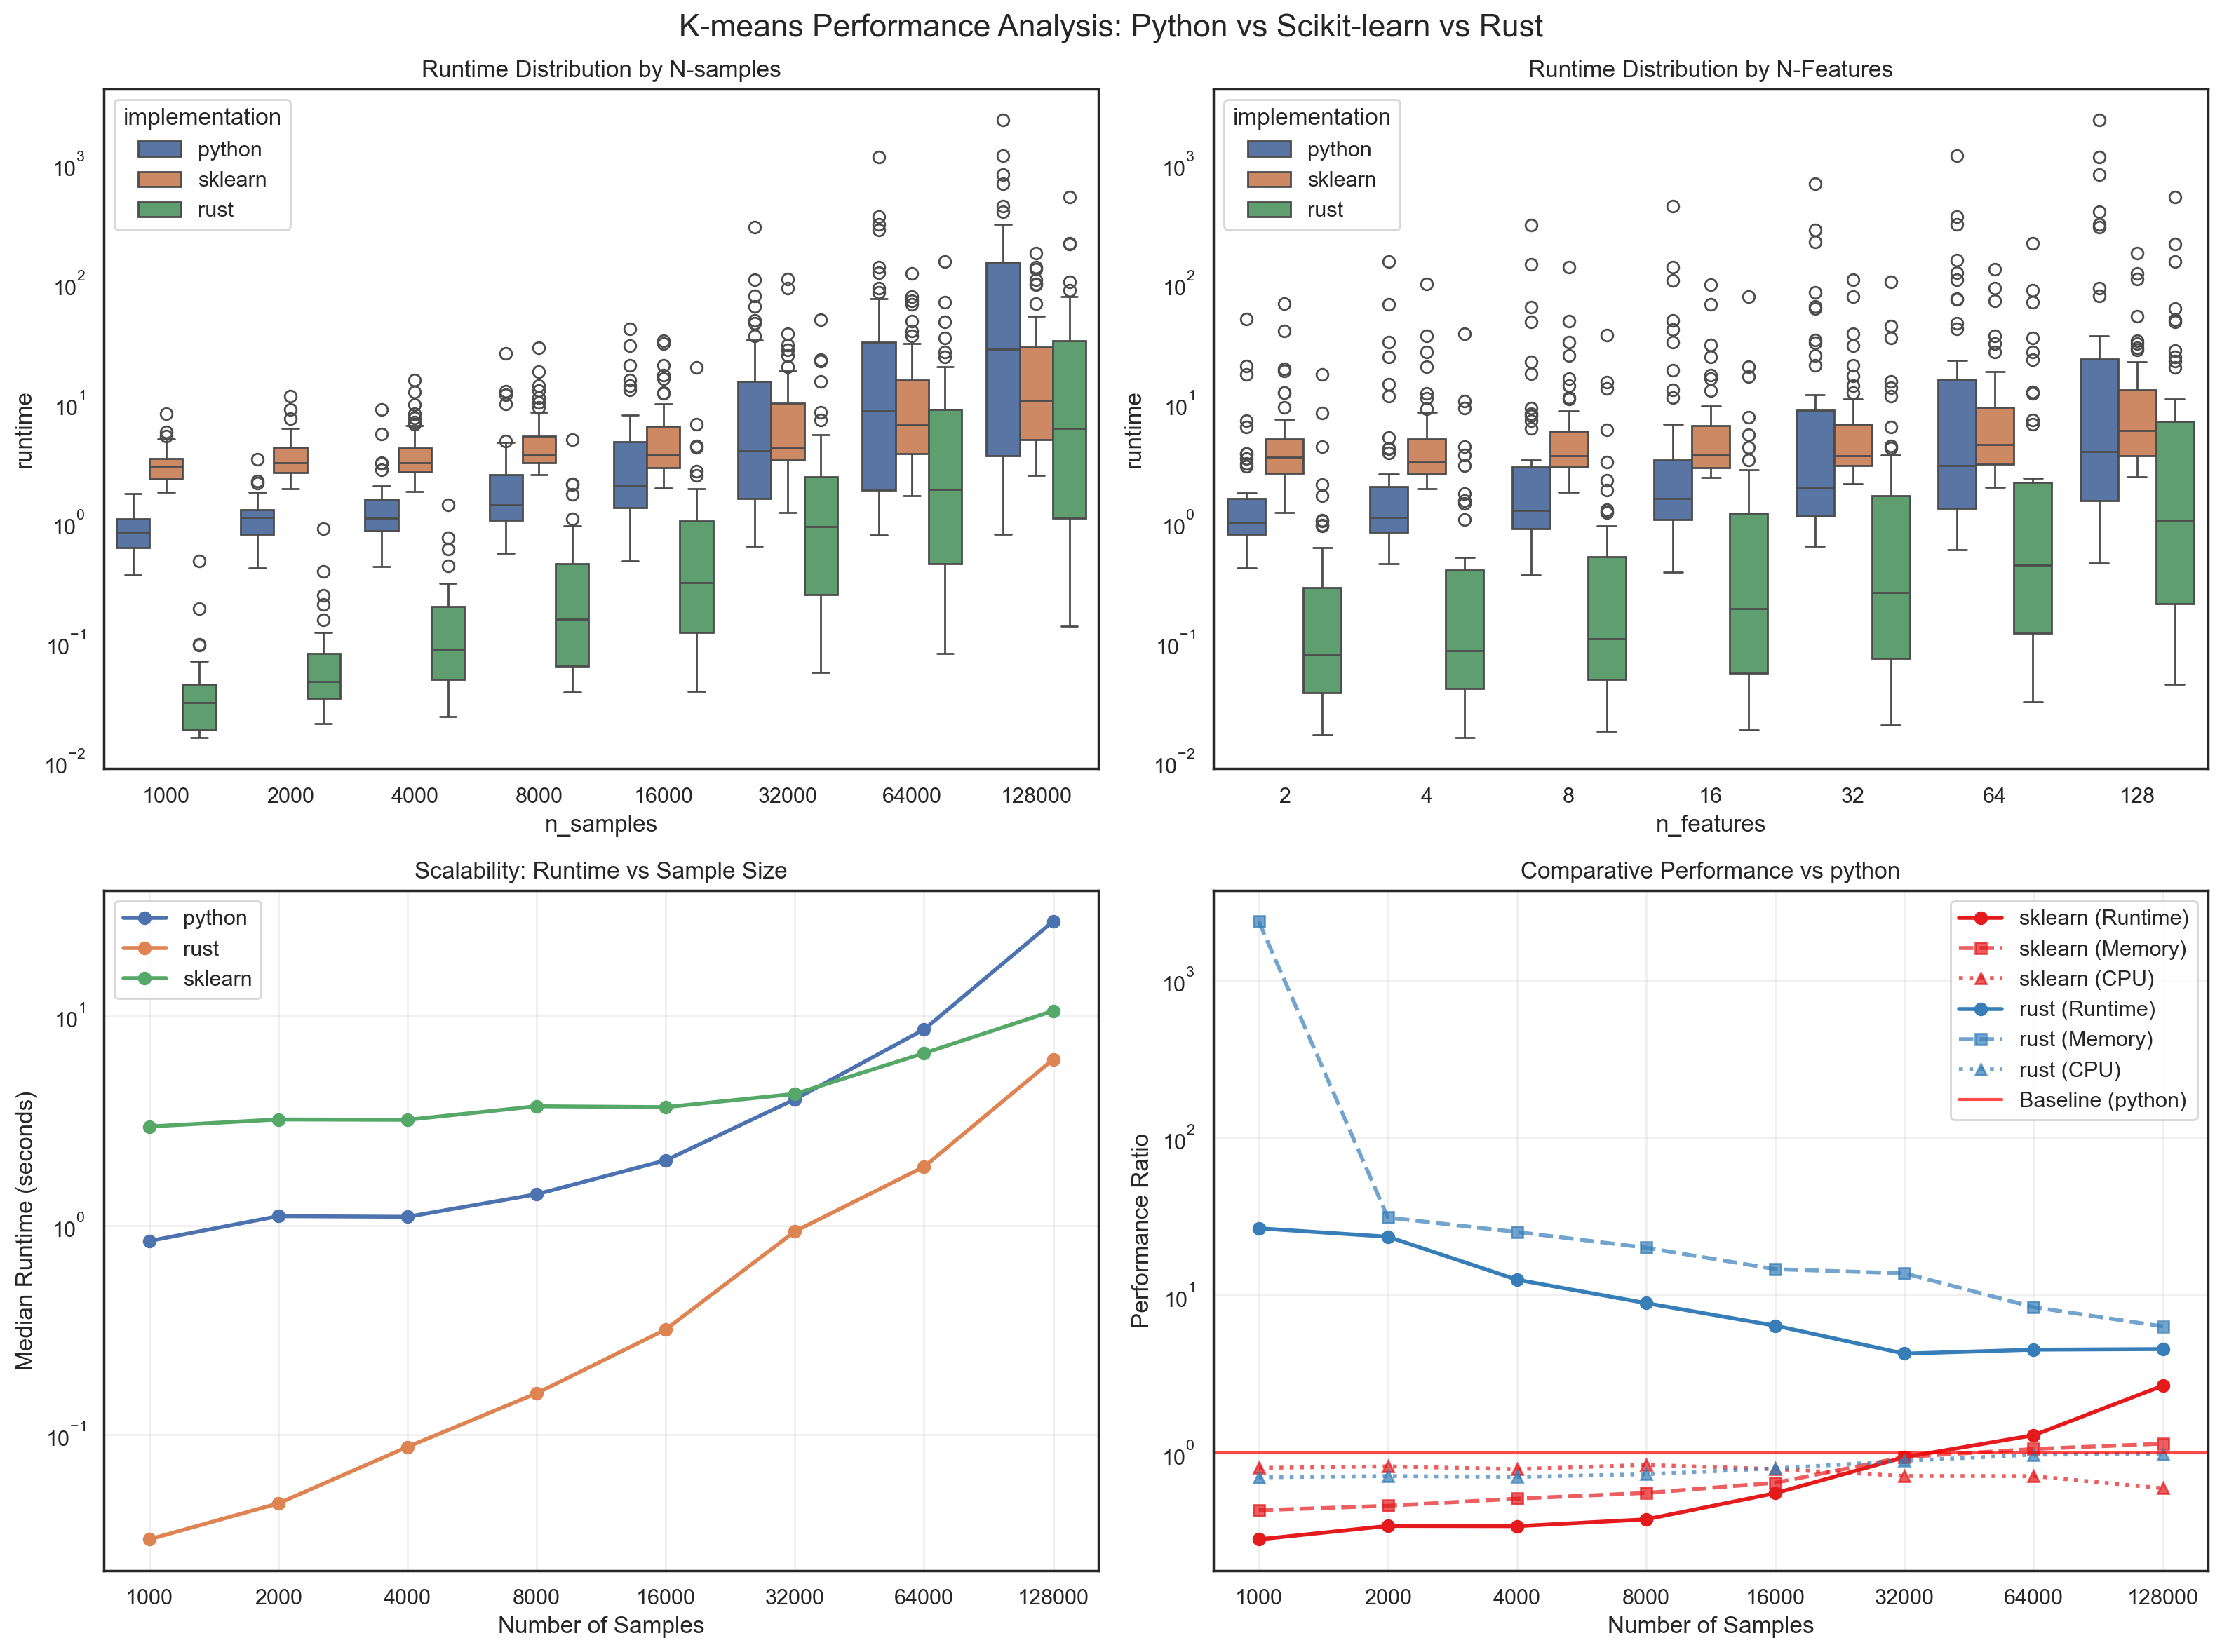

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=200)
fig.suptitle('K-means Performance Analysis: Python vs Scikit-learn vs Rust', fontsize=16)

# Analysis 1: Statistical Performance Summary

sns.boxplot(x="n_samples", y="runtime", hue="implementation", data=data, ax=axes[0,0])
axes[0,0].set_title('Runtime Distribution by N-samples')
axes[0,0].set_yscale('log')

# Analysis 2: Statistical Performance Summary

sns.boxplot(x="n_features", y="runtime", hue="implementation", data=data, ax=axes[0,1])
axes[0,1].set_title('Runtime Distribution by N-Features')
axes[0,1].set_yscale('log')

# Analysis 3: Scalability Analysis
# Median Runtime with each doubling of n-samples

if 'n_samples' in data.columns:
    runtime_medians = data.groupby(['implementation', 'n_samples'])['runtime'].median().reset_index()
    for impl in runtime_medians['implementation'].unique():
        impl_data = runtime_medians[runtime_medians['implementation'] == impl]
        axes[1,0].plot(impl_data['n_samples'].astype(str), impl_data['runtime'], marker='o', label=impl, linewidth=2)
    axes[1,0].set_xlabel('Number of Samples')
    axes[1,0].set_ylabel('Median Runtime (seconds)')
    axes[1,0].set_title('Scalability: Runtime vs Sample Size')
    axes[1,0].set_yscale('log', base=10)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Analysis 4: Relative Performance Analysis
# Calculate speedup ratios compared to baseline (e.g., Python implementation)

if len(data['implementation'].unique()) > 1:
    baseline_impl = 'python'
    if baseline_impl in data['implementation'].values:
        # Create comparative performance analysis across runtime, memory, and CPU
        metrics = ['runtime', 'peak_memory_mb', 'avg_cpu_percent']
        metric_labels = ['Runtime Speedup', 'Memory Efficiency', 'CPU Efficiency']
        
        # Calculate baseline medians for each metric
        baseline_runtime = data[data['implementation'] == baseline_impl].groupby('n_samples')['runtime'].median()
        baseline_memory = data[data['implementation'] == baseline_impl].groupby('n_samples')['peak_memory_mb'].median()
        baseline_cpu = data[data['implementation'] == baseline_impl].groupby('n_samples')['avg_cpu_percent'].median()
        
        comparative_data = []
        
        for impl in data['implementation'].unique():
            if impl != baseline_impl:
                impl_runtime = data[data['implementation'] == impl].groupby('n_samples')['runtime'].median()
                impl_memory = data[data['implementation'] == impl].groupby('n_samples')['peak_memory_mb'].median()
                impl_cpu = data[data['implementation'] == impl].groupby('n_samples')['avg_cpu_percent'].median()
                
                # Calculate ratios (higher is better for runtime speedup, lower is better for memory/CPU)
                runtime_speedup = baseline_runtime / impl_runtime
                memory_efficiency = baseline_memory / impl_memory  # Lower memory usage = higher efficiency
                cpu_efficiency = baseline_cpu / impl_cpu  # Lower CPU usage = higher efficiency
                
                # Create combined dataframe for this implementation
                for n_samples in runtime_speedup.index:
                    comparative_data.append({
                        'n_samples': n_samples,
                        'implementation': impl,
                        'Runtime Speedup': runtime_speedup[n_samples],
                        'Memory Efficiency': memory_efficiency[n_samples] if n_samples in memory_efficiency.index else 1,
                        'CPU Efficiency': cpu_efficiency[n_samples] if n_samples in cpu_efficiency.index else 1
                    })
        
        if comparative_data:
            comp_df = pd.DataFrame(comparative_data)
            
            # Create line charts showing all three metrics
            implementations = comp_df['implementation'].unique()
            colors = plt.cm.Set1(range(len(implementations)))
            
            # Get unique sample sizes for x-axis
            sample_sizes = sorted(comp_df['n_samples'].unique())
            
            for i, impl in enumerate(implementations):
                impl_data = comp_df[comp_df['implementation'] == impl]
                
                # Group by n_samples and get median values for each metric
                grouped = impl_data.groupby('n_samples')[['Runtime Speedup', 'Memory Efficiency', 'CPU Efficiency']].median().reset_index(drop=False)
                
                # Plot line for each metric
                axes[1,1].plot(grouped['n_samples'].astype(str), grouped['Runtime Speedup'], 
                              marker='o', label=f'{impl} (Runtime)', linewidth=2, color=colors[i], linestyle='-')
                axes[1,1].plot(grouped['n_samples'].astype(str), grouped['Memory Efficiency'], 
                              marker='s', label=f'{impl} (Memory)', linewidth=2, color=colors[i], linestyle='--', alpha=0.7)
                axes[1,1].plot(grouped['n_samples'].astype(str), grouped['CPU Efficiency'], 
                              marker='^', label=f'{impl} (CPU)', linewidth=2, color=colors[i], linestyle=':', alpha=0.7)
            
            axes[1,1].set_title(f'Comparative Performance vs {baseline_impl}')
            axes[1,1].set_xlabel('Number of Samples')
            axes[1,1].set_ylabel('Performance Ratio')
            axes[1,1].set_yscale('log', base=10)
            axes[1,1].axhline(y=1, color='red', linestyle='-', alpha=0.7, label=f'Baseline ({baseline_impl})')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/analysis.png")

### Detailed Statistical Analysis


In [30]:
print("=== Performance Analysis Summary ===")

print("\n1. Runtime Statistics by Implementation:")

data.groupby('implementation')['runtime'].describe()

=== Performance Analysis Summary ===

1. Runtime Statistics by Implementation:


,count,mean,std,min,25%,50%,75%,max
implementation,,,,,,,,
python,336.0,36.322592,174.243266,0.368760,0.974553,1.558322,5.585189,2351.286464
rust,336.0,7.026637,35.959168,0.015930,0.055979,0.212812,1.431079,529.290959
sklearn,336.0,10.491545,21.374096,1.220021,2.924781,3.732470,7.376107,179.496680


In [35]:
print("\n2. Performance Ranking (by median runtime):")

median_performance = data.groupby('implementation')['runtime'].median().sort_values()

median_performance


2. Performance Ranking (by median runtime):


implementation
rust       0.212812
python     1.558322
sklearn    3.732470
Name: runtime, dtype: float64

In [36]:

print("\n3. Consistency Analysis (Coefficient of Variation):")

cv_analysis = data.groupby('implementation')['runtime'].agg(['mean', 'std'])
cv_analysis['cv'] = cv_analysis['std'] / cv_analysis['mean']

cv_analysis.sort_values('cv')


3. Consistency Analysis (Coefficient of Variation):


,mean,std,cv
implementation,,,
sklearn,10.491545,21.374096,2.037269
python,36.322592,174.243266,4.797104
rust,7.026637,35.959168,5.117551



#### Additional memory analysis if available

In [37]:
print("\n4. Memory Usage Statistics:")

data.groupby('implementation')['memory_usage'].describe()


4. Memory Usage Statistics:


,count,mean,std,min,25%,50%,75%,max
implementation,,,,,,,,
python,336.0,255.628395,332.026407,67.921875,82.207031,126.460938,282.246094,2361.453125
rust,336.0,23.329148,37.800693,0.031250,2.820312,7.289062,25.382812,234.468750
sklearn,336.0,280.741257,153.281963,161.625000,180.027344,223.859375,320.347656,1075.390625


In [27]:

# Performance efficiency score (lower is better)
if len(data.columns) > 3:  # Assuming more metrics are available
    print("\n5. Performance Efficiency Score:")
    efficiency_data = data.groupby('implementation').agg({
        'runtime': 'median',
        'memory_usage': 'median' if 'memory_usage' in data.columns else 'runtime'
    })
    
    # Normalize scores (0-1 scale, lower is better)
    for col in efficiency_data.columns:
        efficiency_data[f'{col}_normalized'] = efficiency_data[col] / efficiency_data[col].max()
    
    if 'memory_usage' in data.columns:
        efficiency_data['efficiency_score'] = (efficiency_data['runtime_normalized'] +  efficiency_data['memory_usage_normalized']) / 2
    else:
        efficiency_data['efficiency_score'] = efficiency_data['runtime_normalized']
    
    print(efficiency_data[['efficiency_score']].sort_values('efficiency_score'))


5. Performance Efficiency Score:
                efficiency_score
implementation                  
rust                    0.044789
python                  0.491208
sklearn                 1.000000
